Configuration & Path Setup

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")

# 2. Import Custom Modules
from src.data_loader import ClinicalTrialLoader
from src.preprocessing_txt import get_pipeline

Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data


 Smart Data Loading (Auto-Generation)

In [3]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (105336, 32)


Temporal Split (Time Travel) <br>
Why: We sort by date to ensure strict separation of Past (Train) and Future (Test).

In [4]:
# 1. Sort by Start Year (Crucial for Time Series/Evolution)
df = df.sort_values('start_year').reset_index(drop=True)

# 2. Define Split Point (80% Train / 20% Test)
split_idx = int(len(df) * 0.8)

# 3. Split
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 4. Define Features (X) and Target (y)
target_col = 'target'
# We drop ID and Status (Leakage)
drop_cols = [target_col, 'overall_status', 'nct_id']

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_col]

# 5. Verification (The "Reality Check")
print(f"Train Set: {train_df['start_year'].min()} - {train_df['start_year'].max()} (n={len(train_df)})")
print(f"Test Set:  {test_df['start_year'].min()} - {test_df['start_year'].max()} (n={len(test_df)})")

Train Set: 2000.0 - 2019.0 (n=84268)
Test Set:  2019.0 - 2024.0 (n=21068)


dummy classifier (basline assessment)

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("--- BASELINE: DUMMY CLASSIFIER ---")

# 1. Create & Fit (Strategy: Always predict the majority class)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# 2. Predict
y_pred_dummy = dummy.predict(X_test)

# 3. Basic Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dummy):.4f}")
# Note: Precision/Recall will likely be 0.0 if the majority class is 0 (Completed)
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dummy):.4f}")
print("\nInterpretation: This is the score you get by doing absolutely nothing.")

--- BASELINE: DUMMY CLASSIFIER ---
Accuracy:  0.7269
Precision: 0.0000
Recall:    0.0000

Interpretation: This is the score you get by doing absolutely nothing.


Build Pipeline

In [8]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Ensure we default to pandas for the final model fitting,
# but we will handle the inspection step carefully below.
set_config(transform_output="pandas")

model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=0.01,
        max_iter=1000,
        random_state=42
    ))
])

Inspect data and fit

In [10]:
from sklearn import config_context
import pandas as pd

# 2. Inspect and Fit

print("--- INSPECTION STEP ---")
preprocessor = model.named_steps['preprocessor']

# A. Use config_context to temporarily disable pandas output
#    This allows the OneHotEncoder to return a sparse matrix without error.
with config_context(transform_output="default"):
    X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

# B. Convert to Dense (if it is a sparse matrix)
if hasattr(X_train_preprocessed, "toarray"):
    X_train_preprocessed = X_train_preprocessed.toarray()

# C. Get Feature Names and Create DataFrame
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feat_{i}" for i in range(X_train_preprocessed.shape[1])]

X_train_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)

# D. View the data
print(f"Shape of preprocessed data: {X_train_df.shape}")
print("First 5 rows of preprocessed X:")
print(X_train_df.head())

print("\n--- TRAINING STEP ---")
print(f"Training Logistic Regression on {len(X_train)} trials...")

# E. Fit the full model
# This will re-run the preprocessor using the global settings (likely pandas output)
# and then fit the classifier.
model.fit(X_train, y_train)
print("Training Complete.")

--- INSPECTION STEP ---
Shape of preprocessed data: (84268, 126)
First 5 rows of preprocessed X:
   competition_niche  competition_broad  num_primary_endpoints  \
0          -1.305827          -2.189352               -0.50873   
1           0.679523           0.761092               -0.50873   
2           0.679523           0.761092               -0.50873   
3          -0.301131          -0.432578               -0.50873   
4          -1.917339          -2.519837               -0.50873   

   number_of_arms  start_year  phase_ordinal  is_international_1  \
0       -0.065983   -2.183634            1.0                 0.0   
1       -0.065983   -2.183634            0.5                 0.0   
2       -0.065983   -2.183634            0.5                 0.0   
3       -0.065983   -2.183634            0.0                 0.0   
4       -0.065983   -2.183634            0.0                 0.0   

   covid_exposure_1  healthy_volunteers_t  adult_t  ...  truncatedsvd40  \
0               0.0   

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1. Build Pipeline
# We use class_weight='balanced' because clinical trials are often imbalanced (more successes than failures in some phases)
model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=0.01,
        max_iter=1000,
        random_state=42
    ))
])

# 2. Fit
print(f"Training Logistic Regression on {len(X_train)} trials...")
model.fit(X_train, y_train)
print("Training Complete.")

Training Logistic Regression on 84268 trials...
Training Complete.


Evaluation & Visualization

--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.7320  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.4863   (Baseline: 0.2731)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.91      0.42      0.57     15314
           1       0.36      0.89      0.52      5754

    accuracy                           0.55     21068
   macro avg       0.64      0.65      0.55     21068
weighted avg       0.76      0.55      0.56     21068



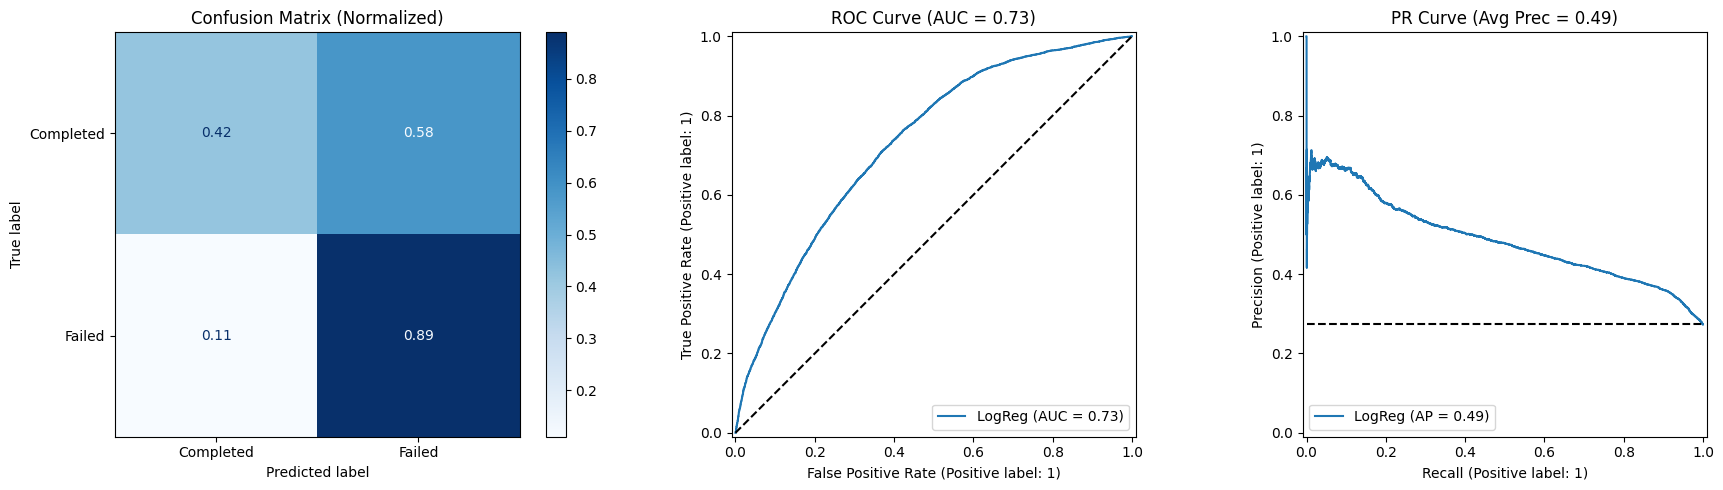

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()

Save Model <br>
Why: Saves the trained pipeline so the Streamlit app can load it later.

In [ ]:
import joblib
import os

# 1. Define the Output Directory
# We use 'project_root' from Cell 1.
models_dir = os.path.join(project_root, 'models')

# 2. Create directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# 3. Define Path & Save
model_filename = 'baseline_pipeline.joblib'
model_path = os.path.join(models_dir, model_filename)

joblib.dump(model, model_path)

# 4. Verification
print(f">>> SUCCESS: Model saved to {model_path}")
# Check size to ensure it's not empty (e.g., < 1KB would be suspicious)
print(f"    File Size: {os.path.getsize(model_path) / 1024:.2f} KB")

In [10]:
df.columns

Index(['nct_id', 'start_date_type', 'start_date', 'study_type',
       'overall_status', 'phase', 'number_of_arms', 'why_stopped', 'target',
       'start_year', 'phase_ordinal', 'covid_exposure', 'includes_us',
       'is_international', 'agency_class', 'allocation', 'intervention_model',
       'primary_purpose', 'masking', 'gender', 'healthy_volunteers', 'adult',
       'child', 'older_adult', 'num_primary_endpoints', 'best_pathology',
       'therapeutic_area', 'therapeutic_subgroup_name', 'competition_broad',
       'competition_niche', 'txt_tags', 'txt_criteria'],
      dtype='object')